In [314]:
#Import of packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import os
from matplotlib import font_manager

#Changes the font  
rc = {"font.family" : "CMU Serif", 
      "mathtext.fontset" : "stix",
     'font.size':12}
plt.rcParams.update(rc)


plt.rcParams['axes.unicode_minus'] = False

In [316]:
#Import of data
df  = pd.read_csv(r'C:\Users\sofie\OneDrive - Aalborg Universitet\Uni\TGA data\heating\ExpDat_CAS_40_24h_heating.csv', skiprows=37, sep=',', header=0, usecols=(0,1,2,3)) 
filename = 'CAS_40_24h'
df_sorted = pd.concat([df['##Temp./°C'], df['Time/min'], df['DSC/(mW/mg)'], df['Mass/%']],axis=1);

In [318]:
#Differentiation of the mass loss pr time 
mass_diff = np.gradient(df_sorted['Mass/%'], df_sorted['Time/min'])
pd.Series(mass_diff)
df_sorted['d(Mass/%)/d(Time/min)'] = mass_diff
df_sorted.head()

,##Temp./°C,Time/min,DSC/(mW/mg),Mass/%,d(Mass/%)/d(Time/min)
0,22.939,0.000,0.013022,100.00000,0.506
1,22.944,0.005,0.012837,100.00253,1.588
2,22.949,0.010,0.012651,100.01588,2.304
3,22.954,0.015,0.012466,100.02557,1.788
4,22.959,0.020,0.012162,100.03376,1.588


In [320]:
#Data in arrays 
df1 = df_sorted['##Temp./°C'] 
df2 = df_sorted['Time/min']
df3 = df_sorted['DSC/(mW/mg)']
df4 = df_sorted['Mass/%']
df5 = df_sorted['d(Mass/%)/d(Time/min)']

In [324]:
#Funktion for getting data snips 
def getrawx(inputT): #funktion der tager den inputværdien, og finder det index hvor forskellen mellem x og inputT er mindst, og retunere dette index. 
    P_inputT = abs(x - inputT).idxmin()
    return P_inputT

#Funktion for smoothing 
def smooth(y, box_pts): #Funktion der udjævner funktionen der sættes ind. 
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#Values 
Tstart = 390
Tend = 505
MinT = Tstart - 20
MaxT = Tstart
x = df1 #temp
y = df4 #Mass
z = smooth(df5,80) #DTG
z = pd.Series(z) #om danner til array, tror jeg, eller i hvertfald noget som getrawx kan læse. 

#Getting the data closes to the MinT and MaxT
xdata = x.iloc[getrawx(MinT):getrawx(MaxT)] 
ydata = y.iloc[getrawx(MinT):getrawx(MaxT)]
zdata = z.iloc[getrawx(MinT):getrawx(MaxT)]

#Making a linar fitting 
p1 = np.polyfit(xdata, ydata,1) #giver a og b, for en ret linje. 
xx1 = np.linspace(MinT-20, (Tstart+Tend)/2+10, 10) #generer 10 værdier i intervsallet T=330 til T=460. 
fit1 = np.poly1d(p1) #Bruges til at evaluere polynomiet, giver i princippet en funktion 

#Repeat of the two previous steps 
MinT = Tend
MaxT = Tend + 30
xdata = x.iloc[getrawx(MinT):getrawx(MaxT)]
ydata = y.iloc[getrawx(MinT):getrawx(MaxT)]

p2 = np.polyfit(xdata, ydata, 1)
xx2 = np.linspace((Tstart+Tend)/2-10, MaxT+20, 10) #fra T=440 til T=580, med 10 punkter? 
fit2 = np.poly1d(p2) # Fitter til en ret linje. 

#Giving a value for the average between the Tstart and Tend 
upper = fit1((Tstart+Tend)/2) #Beregner x værdien når T er gennemsnittet mellem Tstart og Tend
lower = fit2((Tstart+Tend)/2) #Beregner y værdien når T er gennemsnittet mellem Tstart og Tend

#Making empty arrays. 
xfill = [None] * (getrawx(Tend)-getrawx(Tstart)) #Array med tomme pladser som stemmer overens med længden fra T_start til T_end. 
y1 = [None] * (getrawx(Tend)-getrawx(Tstart)) #samme 
y2 = [None] * (getrawx(Tend)-getrawx(Tstart)) #samme

#Filling the arrays. 
for i in range(0,getrawx(Tend)-getrawx(Tstart)): #funktionen fylder de tomme arrays med værdier 
    xfill[i] = x.iloc[getrawx(Tstart)+i] #med værdier fra x, som er Temperaturer. 
    y1[i] = z.iloc[getrawx(Tstart)+i] #med DTG værdierne fra start temp 
    y2[i] = (z.iloc[getrawx(Tend)]-z.iloc[getrawx(Tstart)])/(getrawx(Tend)-getrawx(Tstart))*i+z.iloc[getrawx(Tstart)]
    #hældningen findes, og ganges på det givende værdi svarende til index i, der efter lægges start værdien til. 

# Making a 1D vector 
xfill1 = np.array(xfill).reshape(-1)
y11 = (np.array(y1).reshape(-1))
y22 = (np.array(y2).reshape(-1))

#Bound water calculation 
Twater = 105 #Temperatur hvor alt frit vand er fordampet 
TCaOH = 550 
TGbound_i_min = getrawx(Twater) #finder index nummer som er tættest på 105 grader 
TGbound_min = y[TGbound_i_min] #finder index nummer til den værdi der er tættest på 105 grader. 
TGbound_i_max = getrawx(TCaOH) 
TGbound_max = y[TGbound_i_max]
TGbound = TGbound_min - TGbound_max - (upper-lower) # TG(105) - TG(550) - TG fald fra CaOH. 

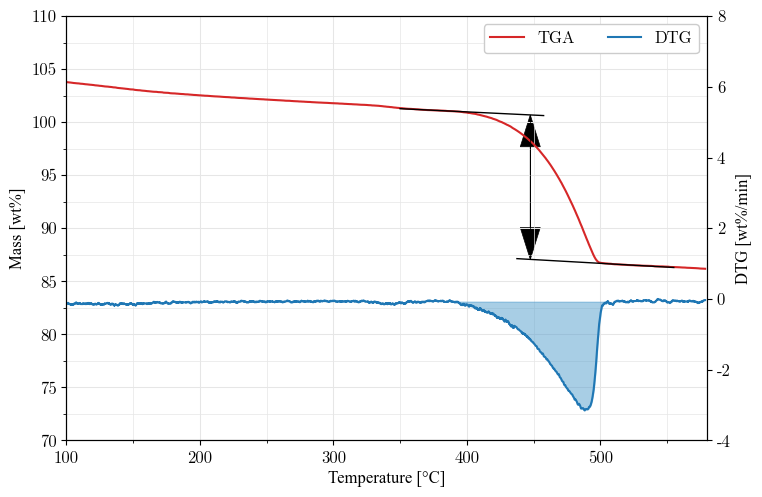

In [328]:
# Plotting 
cm = 1/2.54
fig, ax1 = plt.subplots(figsize=(21*cm,14*cm))

plt.gca().xaxis.set_major_locator(MultipleLocator(100))  # Hovedticks på x-aksen med 2 enheder
plt.gca().yaxis.set_major_locator(MultipleLocator(5))  # Hovedticks på y-aksen med 0.5 enheder
plt.gca().xaxis.set_minor_locator(MultipleLocator(50))  # Mindre ticks på x-aksen
plt.gca().yaxis.set_minor_locator(MultipleLocator(2.5))  # Mindre ticks på y-aksen

plt.grid(which='major', linestyle='-', linewidth=0.75, color='#e6e6e6')
plt.grid(which='minor', linestyle='-', linewidth=0.5, color='#e6e6e6')

ax2 = ax1.twinx()
ax1.set(xlim=[100,580])
ax1.set(ylim=[70,110])
ax2.set(ylim=[-4,8])
ax1.plot(x,y,color = '#d62728', label = 'TGA' ) #her plottes TG (masse %) som funktion af temperatur 
ax2.plot(x,z,color = '#1f77b4', label = 'DTG') #her plottes DTG som funktion af temperatur 
#ax2.plot(x,z.rolling(80).mean(),color = 'C1', label = 'DTG') #her plottes DTG som funktion af temperatur 
ax1.set_xlabel('Temperature [°C]',family='Times New Roman',fontsize = 12)
ax1.set_ylabel('Mass [wt%]',family='Times New Roman',fontsize = 12)
ax2.set_ylabel('DTG [wt%/min]',family='Times New Roman',fontsize = 12)

#Arrows 
ax1.plot([(Tstart+Tend)/2,(Tstart+Tend)/2],[upper,lower],'-k',linewidth=0.5) #vertikal linje ved 450C 
ax1.arrow((Tstart+Tend)/2,(upper+lower)/2,0,(upper-lower)/2, head_width=15, head_length=3, fc='k', ec='k',length_includes_head=True,linewidth = 0.5)
ax1.arrow((Tstart+Tend)/2,(upper+lower)/2,0,-(upper-lower)/2, head_width=15, head_length=3, fc='k', ec='k',length_includes_head=True,linewidth = 0.5)

# Filling the drop blue. 
ax1.plot(xx1,fit1(xx1),'-k',linewidth=1) #
ax1.plot(xx2,fit2(xx2),'-k',linewidth=1)
ax2.fill_between(xfill1,y11,y22, color='#539ecd',alpha = 0.5)
ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.xaxis.set_minor_locator(MultipleLocator(50))

# Making a legend
lines1, labels1 = ax1.get_legend_handles_labels()  # Henter fra ax1
lines2, labels2 = ax2.get_legend_handles_labels()  # Henter fra ax2
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', ncol=2, framealpha=1)

#Saving the figure 
#plt.savefig('C:/Users/sofie/OneDrive - Aalborg Universitet/Skrivebord/' + filename +'_DTG.pdf',dpi=300, bbox_inches = "tight")